## **Travel time**
This part is used to calculate the travel time from Sumatra earthquake to 2 stations

1. pick events
2. pick station
3. get travel time of the homogeneous sphere model
4. get waveform for sac
5. write sac

In [26]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
# create the velocity model
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
# convert distance to degree distance of spherical model
import matplotlib.pyplot as plt
import numpy as np
# to add sac to trace.stats under dictionary format
from obspy.core import AttribDict
# magic function
import os                                       
from obspy import read

client = Client("IRIS")

# initial variables for the event - earthquake
starttime = UTCDateTime("2004-12-26 00:58:53") - 10*60
endtime   = UTCDateTime("2004-12-26 00:58:53") + 10*60
events = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=8.0)
event = events[0]

# event information
print(event.magnitudes[0])
print(event.origins[0])

Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=18508217")
	            mag: 9.0
	 magnitude_type: 'MW'
	  creation_info: CreationInfo(author='HRVD')
Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=3788623")
	          time: UTCDateTime(2004, 12, 26, 0, 58, 52, 50000)
	     longitude: 95.9012
	      latitude: 3.4125
	         depth: 26100.0
	 creation_info: CreationInfo(author='ISC')


## Get station

consider 2 stations:
```
II|SUR|00|BH1
```
```
II|MBAR|00|BH1
```

In [27]:
# xfactor: temporary variable
# obspy applies wildcards
# NOTE: write station is used JUST for PRACTISE PURPOSE

if not os.path.exists("station-xml"):
    os.mkdir("station-xml") # create the folder

stations=["AAK","BFO"] # stations: name of the stations
inventories = [] # inventory: list of station characteristics
for sta in stations:
    xfactor = client.get_stations(
        starttime=starttime, endtime=endtime, 
        network="II", station=sta,
        location="00", channel="BH*",
        level="response")
    # xfactor[0].plot_response(min_freq=1E-4); # uncomment for response plot
    xfactor.write("station-xml/"+sta+".xml",format="STATIONXML")
    inventories.append(xfactor)

## Travel time

In [28]:
model = TauPyModel(model="ak135") # model is ak135 for calculating travel time

degrees = [] # distance degree list
for inv in inventories:
    xfactor = locations2degrees(
        lat1 =event.origins[0].latitude,
        long1=event.origins[0].longitude,
        lat2 =inv[0][0].latitude,
        long2=inv[0][0].longitude)
    degrees.append(xfactor)

arrivals = [] # arrivals: travel time 
for deg in degrees:
    xfactor = model.get_travel_times(
        source_depth_in_km=event.origins[0].depth/1000.,
        distance_in_degree=deg,
        phase_list=["P","pP","S"])
    arrivals.append(xfactor)

print(arrivals[0]) # to show time of P - first element: arrivals[0][0].time
print(arrivals[1])

3 arrivals
	P phase arrival at 482.036 seconds
	pP phase arrival at 489.945 seconds
	S phase arrival at 869.898 seconds
3 arrivals
	P phase arrival at 757.211 seconds
	pP phase arrival at 765.668 seconds
	S phase arrival at 1388.699 seconds


## Wave form
- get wave from the earthquake.
- streams is the list of stream
- each stream is composed of list of traces
- NOTE: each station has its own inventory, stream and a collection of traces

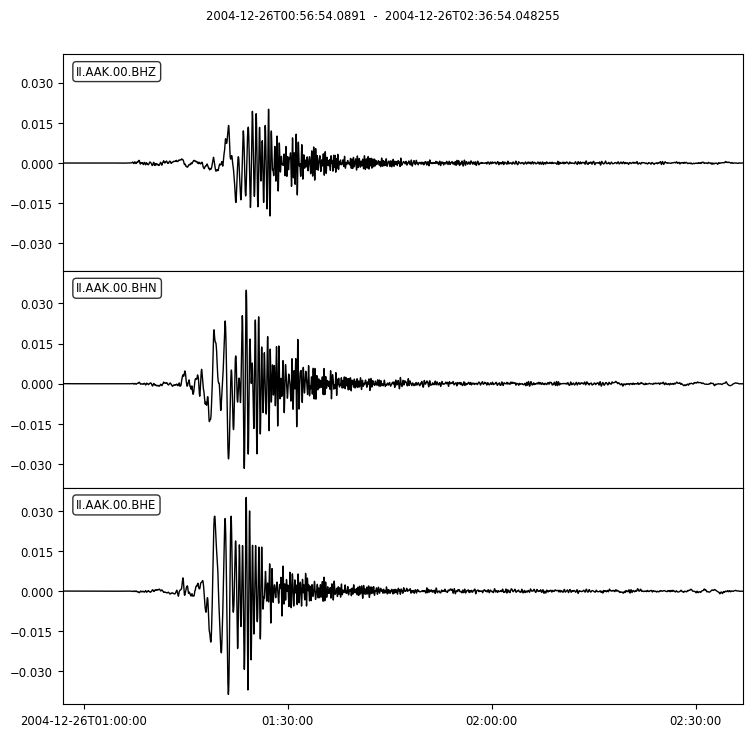

In [29]:
streams = [] 
for sta in enumerate(stations):
    xfactor = client.get_waveforms(
        starttime=event.origins[0].time+arrivals[0][0].time-60*10,
        endtime  =event.origins[0].time+arrivals[0][0].time+60*90,
        network="II", station="AAK", location="00", channel="BH*",
        attach_response=True)
    xfactor.remove_response(output="DISP") #remove response
    streams.append(xfactor)
streams[0].plot();

## Wave path - Example
... not important

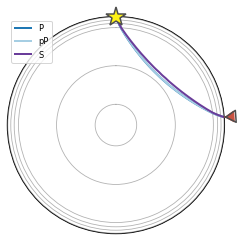

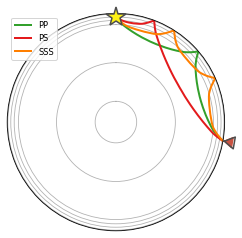

<PolarAxesSubplot:>

In [30]:
arrivals_raypath = model.get_ray_paths(
    source_depth_in_km=event.origins[0].depth/1000.,
    distance_in_degree=degrees[1],
    phase_list=["P","pP","S"])
arrivals_raypath.plot_rays(
    plot_type='spherical',
    phase_list=['PP', 'SSS', 'PS', 'P'],
    plot_all=False, legend=True)

model_example = TauPyModel(model='iasp91')
arrivals_raypath = model_example.get_ray_paths(200, 100, phase_list=['PP', 'SSS', 'PS'])
arrivals_raypath.plot_rays(plot_type='spherical',
                   phase_list=['PP', 'SSS', 'PS', 'P'],
                   plot_all=False, legend=True)

## Matplotlib
... not important

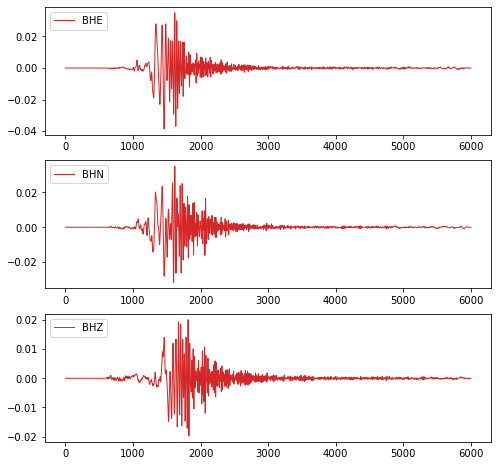

In [31]:


plt.figure(figsize=(8,8))
for i, trace in enumerate(streams[0]):
    j = i + 1
    time = np.arange(trace.stats.npts)*trace.stats.delta
    channel = trace.stats.channel
    plt.subplot(int(str(31)+str(j)))
    plt.plot(time, trace.data, color='tab:red', linewidth=1, label=str(channel))
    plt.legend(loc=2)

## SAC
data to sac, the sac file includes:
- latitude of station(s)
- longitude of station(s)
- latitude of event
- longitude of event
- magnitude of event
- travel time
- waveform

properties:
- trace.stats shows information of trace
- sac uses attribute dictionary
- the data is wrapped into trace.stats.sac


In [32]:
if not os.path.exists("sac-obspy"):
    os.mkdir("sac-obspy") # create the folder

sacd=AttribDict()
sacd.evla = event.origins[0].latitude
sacd.evlo = event.origins[0].longitude
sacd.evdp = event.origins[0].depth/1000.
sacd.mag  = event.magnitudes[0].mag
event_id = str(event.origins[0].time.date)+"T"+\
    str(event.origins[0].time.hour)+"-"+\
    str(event.origins[0].time.minute)+"-"+\
    str(event.origins[0].time.second)


for i, inv in enumerate(inventories):
    sacd.stla = inv[0][0].latitude
    sacd.stlo = inv[0][0].longitude
    sacd.t0   = arrivals[i][0].time
    if not os.path.exists("sac-obspy/"+stations[i]):
        os.mkdir("sac-obspy/"+stations[i])
    for trace in streams[i]:
        trace.stats.sac = sacd
        trace.write("sac-obspy/"+stations[i]+"/"+event_id+'_'
                +trace.stats.station+'_'+trace.stats.channel+'.SAC',
                format='SAC')
print(trace.stats)

               network: II
               station: AAK
              location: 00
               channel: BHZ
             starttime: 2004-12-26T00:56:54.089100Z
               endtime: 2004-12-26T02:36:54.048255Z
         sampling_rate: 19.999969482421875
                 delta: 0.05000007629406173
                  npts: 120000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 62, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 761856})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2004, 12, 26, 2, 36, 54, 98255)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2004, 12, 26, 0, 56, 54, 89100))', "ObsPy 1.2.2: remove_response(fig=None::inventory=None::output='DISP'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)"]
   

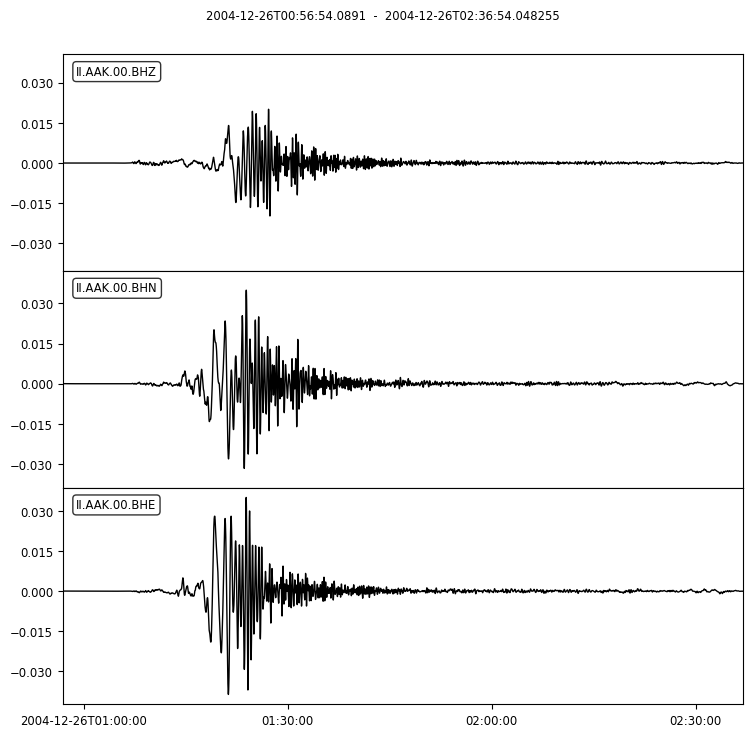

In [33]:
trace1 = read("sac-obspy/AAK/2004-12-26T0-58-52_AAK_BHE.SAC") # test read data
trace2 = read("sac-obspy/AAK/2004-12-26T0-58-52_AAK_BHN.SAC")
trace3 = read("sac-obspy/AAK/2004-12-26T0-58-52_AAK_BHZ.SAC")
stream = trace1 + trace2 + trace3
stream.plot();